In [1]:
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [2]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N 
        - snp.exp(log_S + log_C - log_I) / (2 * N) 
        - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [
            -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 
            snp.sqrt(λ) * snp.exp(-log_I / 2), 
            0
        ],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

Text(0.5, 0, 'Time')

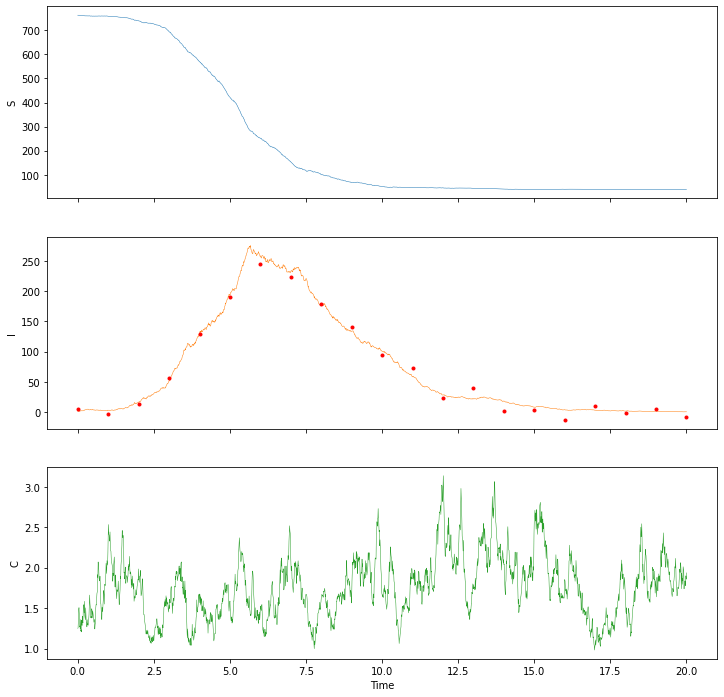

In [3]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763.,  # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.01
t_max = 20.
dt_observation = 1.
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 10.
x_0_obs = np.log(np.array([762., 1., 1.25]))
θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama


Sampling stage: Adaptive warm up [04:48] > Main non-adaptive [05:18]

Chain 1/4: 100%|██████████|1000/1000 [01:18<00:00, 12.66it/s, n_step=503., accept_stat=0.814]

Chain 2/4: 100%|██████████|1000/1000 [01:18<00:00, 12.68it/s, n_step=502., accept_stat=0.827]

Chain 3/4: 100%|██████████|1000/1000 [01:19<00:00, 12.54it/s, n_step=500., accept_stat=0.812]

Chain 4/4: 100%|██████████|1000/1000 [01:20<00:00, 12.44it/s, n_step=493., accept_stat=0.781]

/home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.710,1.699,0.029,5.029,0.029,0.021,3321.0,2636.0,1.0
β,0.363,0.215,0.000,0.698,0.004,0.003,3704.0,1722.0,1.0
σ,0.075,0.086,0.002,0.208,0.002,0.002,3328.0,1689.0,1.0
λ,0.530,0.028,0.475,0.580,0.000,0.000,5163.0,3200.0,1.0
x_0_2,0.481,0.731,-1.085,1.773,0.013,0.011,3192.0,2352.0,1.0


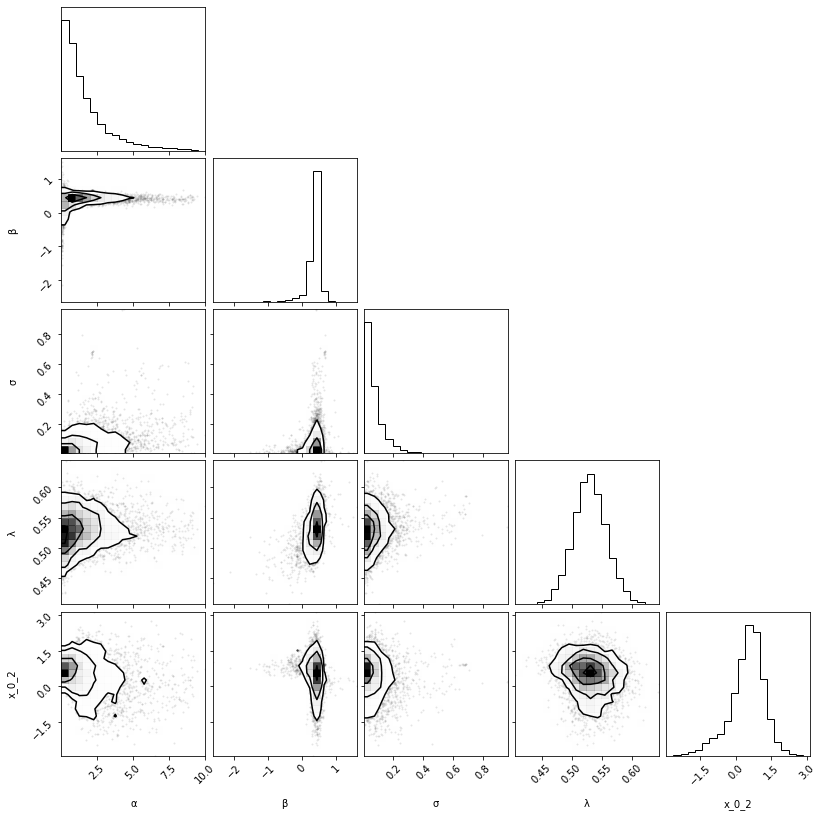

weak_order_2


Sampling stage: Adaptive warm up [12:52] > Main non-adaptive [13:08]

Chain 1/4: 100%|██████████|1000/1000 [03:25<00:00, 4.86it/s, n_step=992., accept_stat=0.950]

Chain 2/4: 100%|██████████|1000/1000 [03:18<00:00, 5.03it/s, n_step=987., accept_stat=0.933]

Chain 3/4: 100%|██████████|1000/1000 [03:11<00:00, 5.23it/s, n_step=959., accept_stat=0.879]

Chain 4/4: 100%|██████████|1000/1000 [03:12<00:00, 5.20it/s, n_step=960., accept_stat=0.882]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.543,2.019,0.327,6.309,0.984,0.751,4.0,13.0,3.31
β,-0.110,1.386,-2.064,2.012,0.685,0.524,4.0,19.0,3.29
σ,0.173,0.116,0.053,0.377,0.053,0.040,5.0,12.0,2.40
λ,3.914,3.235,0.625,10.057,1.568,1.195,5.0,13.0,2.96
x_0_2,1.170,0.326,0.550,1.762,0.131,0.097,6.0,14.0,1.67


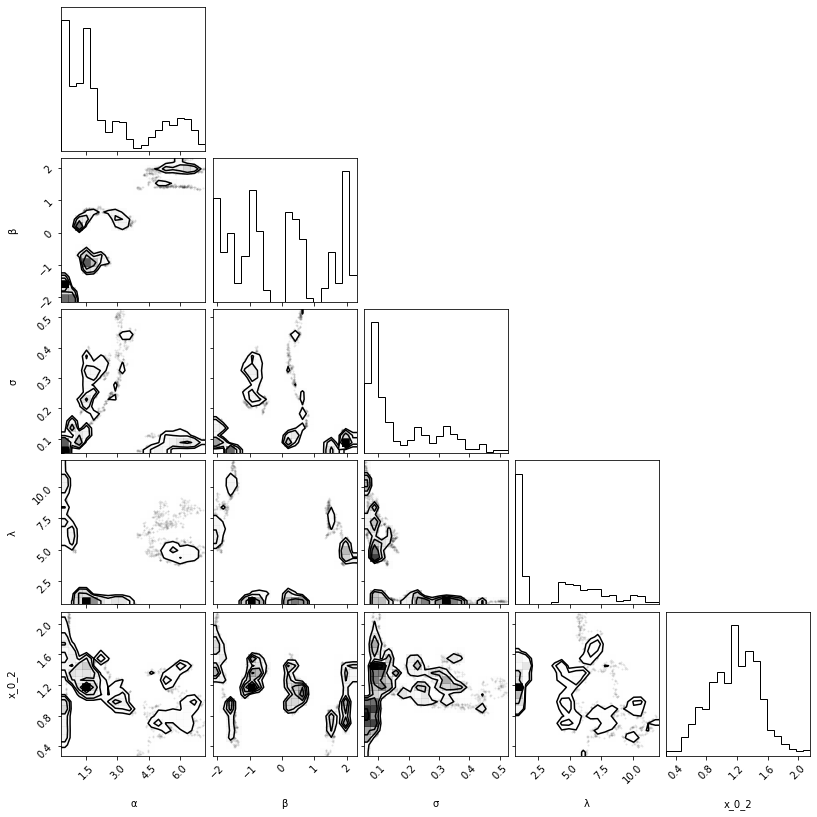

In [4]:
n_chain = 4
n_warm_up_iter = 1000
n_main_iter = 1000
dt_inference = 20 * dt_simulation
t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

common_kwargs = {
    "generate_θ": generate_θ,
    "generate_x_0": generate_x_0,
    "obs_func": obs_func,
    "t_seq": t_seq_inference,
    "dim_u": dim_u,
    "dim_v_0": dim_v_0,
    "obs_noise_std": 10.,
    "obs_time_indices": obs_time_indices,
    "y_obs": y_obs
}
    
for key, generate_x_seq in generate_x_seq_functions.items():
    print(key)
    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq=generate_x_seq, **common_kwargs
    )
    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
    )
    rng = np.random.default_rng(20221114)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [
        mici.adapters.DualAveragingStepSizeAdapter(0.8),
    ]
    init_states = []
    while len(init_states) < n_chain:
        q = rng.standard_normal(dim_q)
        g, v = system._grad_neg_log_dens(q)
        if not (np.any(np.isnan(g)) or np.isnan(v)):
            init_states.append(q)
    final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
    )
    summary = arviz.summary(traces)
    fig = corner.corner(traces)
    display(summary)
    display(fig)
    plt.close(fig)
